### The point of this notebook is mostly to convert the 2-minute photometry to SQLite.
It can take a while to generate the database, but it makes later queries ~1000x faster!

In [1]:
%pylab
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import os

In [3]:
from gPhoton.MCUtils import angularSeparation, print_inline
from gPhoton.galextools import counts2mag, mag2counts

In [4]:
import sqlalchemy as sql #create_engine

In [5]:
import dask.dataframe as dd

In [6]:
photdir = '../photom'

#### Reformat some of the data to play nice with Dask.

In [7]:
def generate_positions(regen=False):
    # Generate "position" tables that have consistent columns for Dask
    n_sources = 0
    photdir = '../photom'
    for i,edir in enumerate(os.listdir(photdir)):
        if 'DS_Store' in edir: # Skip the annoying OSX cruft
            continue
        for csvfile in os.listdir(f'{photdir}/{edir}/'):
            if 'nd-photom' in csvfile:
                photpath = f'{photdir}/{edir}/{csvfile}'
                if os.path.exists(photpath.replace('-photom','-pos')) and not regen:
                    continue
                expt = pd.read_csv(photpath.replace('-photom','-exptime'))
                total_exptime = expt.expt.sum()
                eclipse = int(csvfile.split('-')[0][1:])
                photpath = f'{photdir}/{edir}/{csvfile}'
                phot = pd.read_csv(photpath)
                #print(total_exptime,phot.aperture_sum.values)
                n_sources += len(phot)
                phot['eclipse'] = eclipse
                pos = phot[['eclipse', 'id', 'ra', 'dec', 'xcenter', 'ycenter']]
                pos['exptime'] = total_exptime
                pos['cps'] = np.array(phot.aperture_sum.values)/total_exptime
                pos['cps_err'] = np.sqrt(phot.aperture_sum.values)/total_exptime
                pos['hasmask'] = phot.aperture_sum_mask.values!=0
                pos['hasedge'] = phot.aperture_sum_edge.values!=0
                pos.to_csv(photpath.replace('-photom','-pos'),index=False)
        if not i%1000:
            print_inline(i)
    print_inline('Source position data reformatted to work with Dask.')
    return

%time generate_positions(regen=True)

<ipython-input-7-16bad4ea7335>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['exptime'] = total_exptime
<ipython-input-7-16bad4ea7335>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos['cps'] = np.array(phot.aperture_sum.values)/total_exptime
<ipython-input-7-16bad4ea7335>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

CPU times: user 5min 16s, sys: 18.8 s, total: 5min 35s      
Wall time: 5min 37s


#### Analyze a test visit (e26980).

In [8]:
photfile = f'{photdir}/e26980/e26980-nd-photom.csv'
fn = photfile.split('/')[-1]
eclipse = int(fn.split('-')[0][1:])
exptfile = f'{photdir}/e26980/e26980-nd-exptime.csv'
phot = pd.read_csv(photfile)
expt = pd.read_csv(exptfile)
total_expt = expt.expt.sum()
print(f'Eclipse {eclipse} summary:')
print(f'   * {round(total_expt)} seconds of exposure')
print(f'   * {len(phot)} unique sources detected')
print(f'   * {len(phot.loc[phot.aperture_sum_mask==0])} unflagged sources')

Eclipse 26980 summary:
   * 1063 seconds of exposure
   * 1795 unique sources detected
   * 1728 unflagged sources


RA range  ==> [208.38, 209.62]
Dec range ==> [4.39, 5.64]


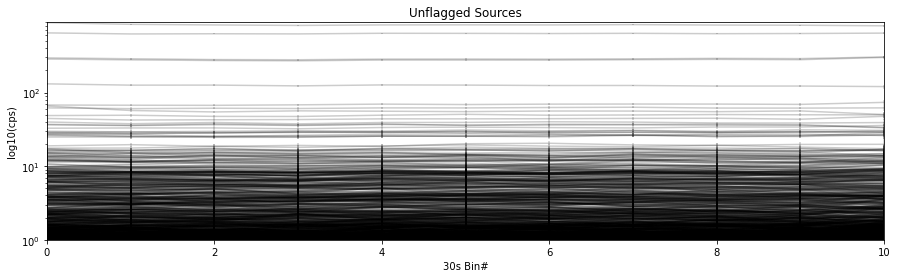

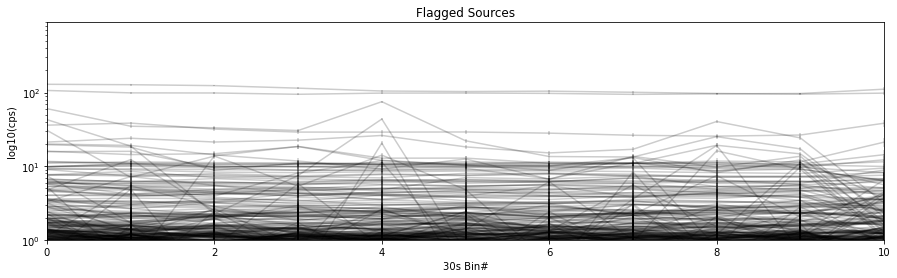

In [9]:
plt.figure(figsize=(15,4))
plt.title('Unflagged Sources')
for index in phot.index.values:
    if ((phot.loc[index].aperture_sum_mask!=0) |
        (phot.loc[index].aperture_sum_edge!=0)):
        continue
    cnt = phot.loc[index][
            ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
        ].values
    cps = cnt / expt.expt.values.flatten()
    cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
    plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
plt.semilogy()
plt.xlabel('30s Bin#')
plt.ylabel('log10(cps)')
plt.xlim([0,10])
plt.ylim([1,900])

plt.figure(figsize=(15,4))
plt.title('Flagged Sources')
for index in phot.index.values:
    if not ((phot.loc[index].aperture_sum_mask!=0) |
        (phot.loc[index].aperture_sum_edge!=0)):
        continue
    cnt = phot.loc[index][
            ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
        ].values
    cps = cnt / expt.expt.values.flatten()
    cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
    plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
plt.semilogy()
plt.xlabel('30s Bin#')
plt.ylabel('log10(cps)')
plt.xlim([0,10])
plt.ylim([1,900])

print(f"RA range  ==> [{np.round(phot.ra.min(),2)}, {np.round(phot.ra.max(),2)}]")
print(f"Dec range ==> [{np.round(phot.dec.min(),2)}, {np.round(phot.dec.max(),2)}]")

#### Now try to do the same thing starting from the full depth photometry catalog...

In [10]:
df = dd.read_csv(f'{photdir}/*/*pos.csv')
# For performance testing purposes, write _all_ of the photometry to a single CSV file... maybe it's faster?
# This makes a ~1.2Gb file.
if not os.path.exists('catalog.csv'):
    %time df.to_csv('catalog.csv', single_file = True)

CPU times: user 4min 20s, sys: 19.7 s, total: 4min 39s
Wall time: 4min 11s


#### Use GJ65 (aka UV Ceti) as the test source.

In [11]:
skypos = (24.76279, -17.94948) # position of UV Ceti
match_radius = 0.005

#### Find every source within `match_radius` of `skypos`

In [12]:
%time pos = df[angularSeparation(skypos[0],skypos[1],df.ra,df.dec)<match_radius][['eclipse','id','ra','dec']].compute()

CPU times: user 1min 17s, sys: 20.3 s, total: 1min 38s
Wall time: 1min 11s


Index(['eclipse', 'id', 'ra', 'dec'], dtype='object')
9
     eclipse   id         ra        dec      dist
692    13648  693  24.762436 -17.950093  0.000699
750    13649  751  24.762278 -17.950073  0.000767
772    13651  773  24.762253 -17.950119  0.000819
814    13655  815  24.762377 -17.950047  0.000689
803    13656  804  24.761947 -17.949810  0.000867
772    13659  773  24.762409 -17.950065  0.000688
691    13662  692  24.762545 -17.949985  0.000556
716    13664  717  24.762496 -17.950021  0.000609
852    13673  853  24.762333 -17.950058  0.000723


([], [])

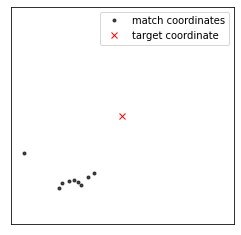

In [13]:
print(pos.keys())
pos['dist'] = angularSeparation(skypos[0],skypos[1],pos.ra.values,pos.dec.values)
print(len(pos))
print(pos)
plt.figure(figsize=(4,4))
plt.plot(pos.ra,pos.dec,'k.',alpha=0.7,label='match coordinates')
plt.plot(skypos[0],skypos[1],'rx',label='target coordinate')
plt.xlim([skypos[0]-max(pos.dist.values)*1.1,skypos[0]+max(pos.dist.values)*1.1])
plt.ylim([skypos[1]-max(pos.dist.values)*1.1,skypos[1]+max(pos.dist.values)*1.1])
plt.legend()
plt.xticks([])
plt.yticks([])

#### Plot all of the lightcurves for matches

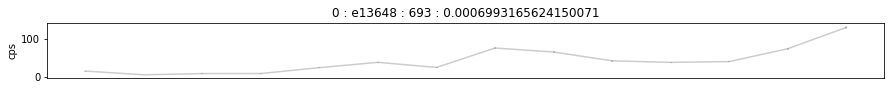

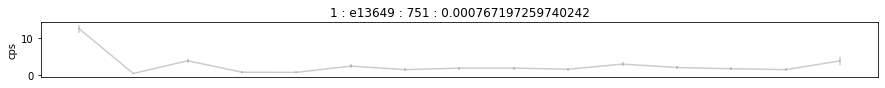

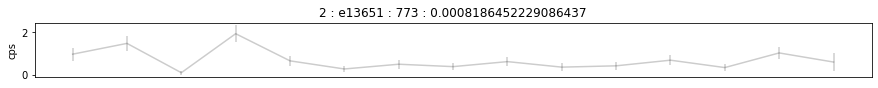

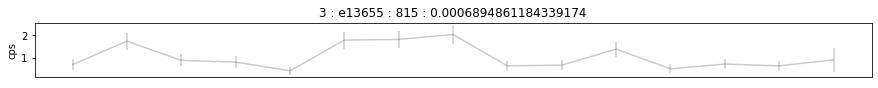

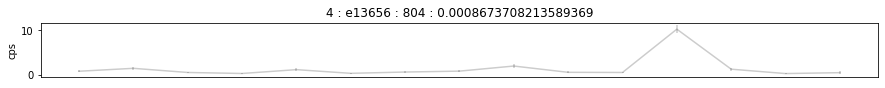

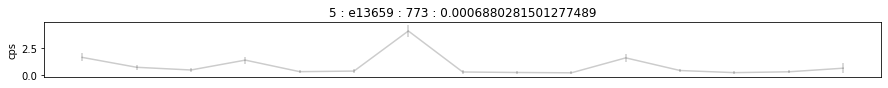

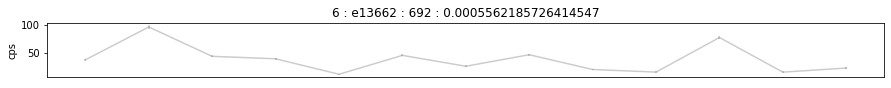

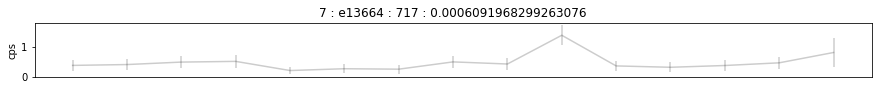

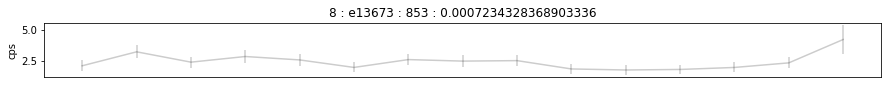

In [14]:
for j in np.arange(len(pos)):
    eclipse = int(pos.iloc[j].eclipse)
    photfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv'
    exptfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv'
    phot = pd.read_csv(photfile)
    expt = pd.read_csv(exptfile)
    total_expt = expt.expt.sum()
    plt.figure(figsize=(15,1))
    plt.title(f'{j} : e{eclipse} : {int(pos.iloc[j].id)} : {pos.iloc[j].dist}')
    cnt = phot.iloc[j][
            ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
        ].values
    cps = cnt / expt.expt.values.flatten()
    cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
    plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
    #plt.xlabel('time index')
    plt.ylabel('cps')
    plt.xticks([])

#### Now define a function that returns all of this data, given a target position (and match radius)

In [15]:
def get_lightcurves(skypos,match_radius=0.005,debug=False):
    pos = df[angularSeparation(skypos[0],skypos[1],df.ra,df.dec)<match_radius][['eclipse','id','ra','dec']].compute()
    pos['dist'] = angularSeparation(skypos[0],skypos[1],pos.ra.values,pos.dec.values)
    if debug:
        plt.figure(figsize=(5,5))
        plt.title(f'{len(pos)} sources found')
        plt.plot(pos.ra,pos.dec,'k.',alpha=0.7)
        plt.plot(skypos[0],skypos[1],'rx')
        plt.xlim([skypos[0]-max(pos.dist.values)*1.1,skypos[0]+max(pos.dist.values)*1.1])
        plt.ylim([skypos[1]-max(pos.dist.values)*1.1,skypos[1]+max(pos.dist.values)*1.1])
        plt.xticks([])
        plt.yticks([])
    data = {}
    total_expt = 0
    for j in np.arange(len(pos)):
        eclipse = int(pos.iloc[j].eclipse)
        photfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv'
        exptfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv'
        phot = pd.read_csv(photfile)
        expt = pd.read_csv(exptfile)
        total_expt += expt.expt.sum()
        cnt = phot.iloc[j][
                ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
            ].values
        cps = cnt / expt.expt.values.flatten()
        cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
        if debug:
            plt.figure(figsize=(15,3))
            plt.title(f'{j} : e{eclipse} : {int(pos.iloc[j].id)} : {pos.iloc[j].dist}')
            plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
            plt.ylabel('cps')
            plt.xticks([])
        data[j] = {'eclipse':eclipse,
                   't0':expt.t0.min(),
                   't1':expt.t1.max(),
                   'photfile':photfile,
                   'exptfile':exptfile,
                   'photdata':phot,
                   'exptdata':expt,
                   'counts':cnt,
                   'cps':cps,
                   'cps_err':cps_err}
    print(f'Returning {int(total_expt)} seconds of exposure.')
    return data

#### It seems to take ~1 minute to search the csv tables with Dask (on my laptop)

In [16]:
%time data = get_lightcurves((24.76279, -17.94948))

Returning 13520 seconds of exposure.
CPU times: user 1min 18s, sys: 19.9 s, total: 1min 38s
Wall time: 1min 11s


#### Test performance with SQLite

In [17]:
# Convert the csv data to SQLite... this takes a few minutes...
catdbfile = 'catalog.db'
rerun = False
engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
if not os.path.exists(catdbfile) or rerun:
    for i,edir in enumerate(os.listdir(photdir)):
        if 'DS_Store' in edir: # Skip the annoying OSX cruft
            continue
        for csvfile in os.listdir(f'{photdir}/{edir}/'):
            if 'nd-pos' in csvfile:
                pospath = f'{photdir}/{edir}/{csvfile}'
                pos = pd.read_csv(pospath)
                pos.to_sql('gfcat', con=engine, if_exists='append' if i!=0 else 'replace')
        if not i%100:
            print_inline(i)
    # Index on RA, Dec --- this is what we're most interested in searching against
    engine.execute("CREATE INDEX 'ix_gfcat' ON 'gfcat' ('ra', 'dec')")
print_inline('Source position data dumped to SQLite.')

#### It seems to take ~1 second with SQLite out of the box. I can live with that!
#### But with indexing on (ra, dec), it now takes ~2ms!!!

In [18]:
%time pos = engine.execute(f"SELECT eclipse, id, ra, dec FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}").fetchall()
print(pos)

CPU times: user 1.02 ms, sys: 1.17 ms, total: 2.19 ms
Wall time: 1.01 ms
[(13656, 804, 24.76194682622797, -17.949810018541942), (13651, 773, 24.76225267203205, -17.950119437706594), (13649, 751, 24.76227796230105, -17.950072714365376), (13673, 853, 24.762332525234328, -17.950057883168448), (13655, 815, 24.762377321355753, -17.950046800082916), (13659, 773, 24.7624091197675, -17.950064885674323), (13648, 693, 24.762436250102358, -17.95009301712016), (13664, 717, 24.76249600192245, -17.950021197930887), (13662, 692, 24.76254507235281, -17.949985061523446)]


In [19]:
# Modify this function to use sqlite...
def get_lightcurves(skypos,match_radius=0.005,debug=False,catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = np.array(engine.execute(f"SELECT eclipse, id, ra, dec FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}").fetchall())
    engine.dispose()
    pos = pd.DataFrame({'eclipse':out[:,0],'id':out[:,1],
                        'ra':out[:,2],'dec':out[:,3]})    #pos = df[angularSeparation(skypos[0],skypos[1],df.ra,df.dec)<match_radius][['eclipse','id','ra','dec']].compute()
    pos['dist'] = angularSeparation(skypos[0],skypos[1],pos.ra.values,pos.dec.values)
    if debug:
        plt.figure(figsize=(5,5))
        plt.title(f'{len(pos)} sources found')
        plt.plot(pos.ra,pos.dec,'k.',alpha=0.7)
        plt.plot(skypos[0],skypos[1],'rx')
        plt.xlim([skypos[0]-max(pos.dist.values)*1.1,skypos[0]+max(pos.dist.values)*1.1])
        plt.ylim([skypos[1]-max(pos.dist.values)*1.1,skypos[1]+max(pos.dist.values)*1.1])
        plt.xticks([])
        plt.yticks([])
    data = {}
    total_expt = 0
    for j in np.arange(len(pos)):
        eclipse = int(pos.iloc[j].eclipse)
        photfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv'
        exptfile = f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv'
        phot = pd.read_csv(photfile)
        expt = pd.read_csv(exptfile)
        total_expt += expt.expt.sum()
        cnt = phot.iloc[j][
                ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
            ].values
        cps = cnt / expt.expt.values.flatten()
        cps_err = np.sqrt(cnt) / expt.expt.values.flatten()
        if debug:
            plt.figure(figsize=(15,3))
            plt.title(f'{j} : e{eclipse} : {int(pos.iloc[j].id)} : {pos.iloc[j].dist}')
            plt.errorbar(np.arange(len(expt)),cps,yerr=cps_err*3,fmt='k-',alpha=0.2)
            plt.ylabel('cps')
            plt.xticks([])
        data[j] = {'eclipse':eclipse,
                   't0':expt.t0.min(),
                   't1':expt.t1.max(),
                   'photfile':photfile,
                   'exptfile':exptfile,
                   'photdata':phot,
                   'exptdata':expt,
                   'counts':cnt,
                   'cps':cps,
                   'cps_err':cps_err}
    print(f'Returning {int(total_expt)} seconds of exposure.')
    return data

In [20]:
%time data = get_lightcurves((24.76279, -17.94948))

Returning 13520 seconds of exposure.
CPU times: user 103 ms, sys: 24.1 ms, total: 127 ms
Wall time: 126 ms


In [21]:
def gfcat_count(catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = engine.execute(f"SELECT COUNT(eclipse) FROM gfcat ").fetchall()
    print(out)
    #pos = pd.DataFrame({'ra':out[:,0],'dec':out[:,1]})    #pos = df[angularSeparation(skypos[0],skypos[1],df.ra,df.dec)<match_radius][['eclipse','id','ra','dec']].compute()
    engine.dispose()
    return

%time gfcat_count()

[(18340721,)]
CPU times: user 756 ms, sys: 306 ms, total: 1.06 s
Wall time: 1.06 s


In [22]:
def get_lightcurve(eclipse,ix,photdir = '../photom'):
    # given an eclipse and source id, return the lightcurve data
    phot = pd.read_csv(f'{photdir}/e{eclipse}/e{eclipse}-nd-photom.csv')
    expt = pd.read_csv(f'{photdir}/e{eclipse}/e{eclipse}-nd-exptime.csv')
    total_expt = expt.expt.sum()
    cnt = np.array(phot.iloc[ix][
        ["aperture_sum_{i}".format(i=i) for i in np.arange(len(expt))]
            ].values)
    exptimes = expt.expt.values,
    cps = cnt / exptimes
    cps_err = np.sqrt(cnt) / exptimes
    return pd.DataFrame({'t0':expt.t0,'t1':expt.t1,
                         'expt':exptimes[0],'counts':cnt,
                         'cps':(cnt / exptimes[0]),
                         'cps_err':(np.sqrt(cnt) / exptimes[0])})

def plot_lightcurve(eclipse,ix,photdir = '../photom',title=''):
    # given an eclipse and source id, plot the lightcurve
    lc = get_lightcurve(eclipse,ix,photdir=photdir)
    plt.figure(figsize=(15,1))
    plt.title(title if title else f'e{eclipse} : {ix}')
    plt.errorbar(np.array(lc['t0'])-min(lc['t0']),lc['cps'],yerr=lc['cps_err']*3,fmt='k-',alpha=0.6)
    plt.xlabel('time (s)')
    plt.ylabel('cps')
    plt.xticks([])
    return

CPU times: user 25.9 ms, sys: 3.04 ms, total: 28.9 ms
Wall time: 27.7 ms


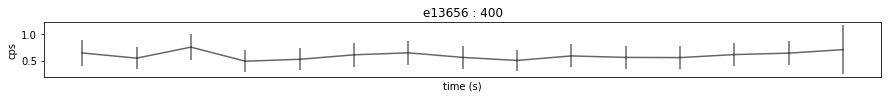

In [23]:
%time plot_lightcurve(13656,400,photdir = '../photom')

#### Implement a cone search

In [24]:
def query(query,catdbfile='catalog.db'):
    engine = sql.create_engine(f'sqlite:///{catdbfile}', echo=False)
    out = engine.execute(query).fetchall()
    engine.dispose()
    return out

%time brightstars = query(f"SELECT eclipse, id FROM gfcat WHERE hasmask=0 AND hasedge=0 AND cps>622") # 2x the 10% rolloff
print(f'There are {len(brightstars)} very bright stars.\n')

def conesearch(skypos,match_radius=0.005,catdbfile='catalog.db'):
    out = np.array(query(f"SELECT eclipse, id, ra, dec, xcenter, ycenter FROM gfcat WHERE ra >= {skypos[0]-match_radius} AND ra <={skypos[0]+match_radius} AND dec>= {skypos[1]-match_radius} AND dec<={skypos[1]+match_radius}"))
    dist_ix = np.where(angularSeparation(skypos[0],skypos[1],
                                         out[:,2],out[:,3])<=match_radius)
    return pd.DataFrame({'eclipse':np.array(out[:,0][dist_ix],dtype='int16'),
                         'id':np.array(out[:,1][dist_ix],dtype='int16'),
                         'ra':out[:,2][dist_ix],
                         'dec':out[:,3][dist_ix],
                         'xcenter':out[:,4][dist_ix],
                         'ycenter':out[:,5][dist_ix]})

%time uvceti = conesearch((24.76279, -17.94948)) # UV Ceti
print(f'There are {len(uvceti)} UV Ceti observations.')

CPU times: user 1.44 s, sys: 297 ms, total: 1.74 s
Wall time: 1.74 s
There are 2795 very bright stars.

CPU times: user 2.09 ms, sys: 354 µs, total: 2.45 ms
Wall time: 2.26 ms
There are 9 UV Ceti observations.


In [25]:
uvceti

,eclipse,id,ra,dec,xcenter,ycenter
0,13656,804,24.761947,-17.949810,1475.377676,1647.866499
1,13651,773,24.762253,-17.950119,1588.837787,1694.283407
2,13649,751,24.762278,-17.950073,1450.107072,1685.207138
3,13673,853,24.762333,-17.950058,1452.230731,1812.182759
4,13655,815,24.762377,-17.950047,1469.968383,1649.010332
5,13659,773,24.762409,-17.950065,1451.684387,1652.552756
6,13648,693,24.762436,-17.950093,1442.961441,1594.884882
7,13664,717,24.762496,-17.950021,1436.290557,1635.606763
8,13662,692,24.762545,-17.949985,1520.025436,1518.976198
